# 6.1: Credit Risk Score Project

#In this session we'll learn about decision trees and ensemble learning algorithms. The questions that we try to address this week are, "What are decision trees? How are they different from ensemble algorithms? How can we implement and fine-tune these models to make binary classification predictions?"

#To be specific, we'll use credit scoring data to build a model that predicts whether a bank should lend loan to a client or not. The bank takes these decisions based on the historical record.

#In the credit scoring classification problem,

#if the model returns 0, this means, the client is very likely to payback the loan and the bank will approve the loan.
#if the model returns 1, then the client is considered as a defaulter and the bank may not approval the loan.

# 6.2: Data Cleaning and Preparation:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("C:\\Users\\emman\\Desktop\\ML-Zoomcamp\\raw.githubusercontent.com_gastonstat_CreditScoring_master_CreditScoring.csv")

In [3]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()                     #lowercase of the columns
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


#some categorical columns need conversion to string objects:

In [5]:
df['status'].value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [6]:
status_values = {
    1:'ok', 
    2:'default', 
    0:'unk'
}

df['status'] = df['status'].map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df['home'] = df['home'].map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df['marital'] = df['marital'].map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df['records'] = df['records'].map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df['job'] = df['job'].map(job_values)

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()                  #to show numerical statistical info of dataset df

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


#replace the max numbers of income, assets and amount with nan bcos they are too large:

In [9]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
# remove the unknown option from status bcos it's not needed in the data and reset index

df = df[df['status'] != 'unk'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
# get the ys of each dataset, set contents to 1 or 0

y_train = (df_train['status'] == 'default').astype('int').values
y_val = (df_val['status'] == 'default').astype('int').values
y_test = (df_test['status'] == 'default').astype('int').values

In [15]:
del df_train['status']
del df_val['status']  
del df_test['status']

In [16]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


# 6.3: Decision Trees

#creating a decision tree function manually and test with the first index

In [17]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'partime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [18]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [19]:
assess_risk(xi)                     # this decision shows the customer xi will not default.

'ok'

#using sklearn for decision tree, Dictvectorizer and convert the train and val dataset using one-hot encoding

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [21]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [22]:
train_dicts[:2]                     #confirm the first 2 records changed to dictionary

[{'seniority': 10,
  'home': 'owner',
  'time': 36,
  'age': 36,
  'marital': 'married',
  'records': 'no',
  'job': 'freelance',
  'expenses': 75,
  'income': 0.0,
  'assets': 10000.0,
  'debt': 0.0,
  'amount': 1000,
  'price': 1400},
 {'seniority': 6,
  'home': 'parents',
  'time': 48,
  'age': 32,
  'marital': 'single',
  'records': 'yes',
  'job': 'fixed',
  'expenses': 35,
  'income': 85.0,
  'assets': 0.0,
  'debt': 0.0,
  'amount': 1100,
  'price': 1330}]

In [23]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [24]:
dv.get_feature_names_out()                            #feature names of the train data X_train

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
train_val = df_val.fillna(0).to_dict(orient='records')                              #validation dataset conversion

In [27]:
X_val = dv.transform(train_val)                                                           #validation dataset
X_val

array([[3.10e+01, 5.50e+02, 0.00e+00, ..., 0.00e+00, 6.00e+00, 3.60e+01],
       [3.80e+01, 1.00e+03, 0.00e+00, ..., 0.00e+00, 1.80e+01, 6.00e+01],
       [4.00e+01, 7.00e+02, 0.00e+00, ..., 1.00e+00, 1.70e+01, 2.40e+01],
       ...,
       [3.60e+01, 3.90e+03, 2.90e+04, ..., 1.00e+00, 2.00e+00, 6.00e+01],
       [2.50e+01, 3.00e+02, 0.00e+00, ..., 1.00e+00, 3.00e+00, 2.40e+01],
       [3.20e+01, 1.55e+03, 6.00e+03, ..., 0.00e+00, 1.50e+01, 6.00e+01]])

In [28]:
y_pred = dt.predict_proba(X_val)[:,1]
y_pred

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0.

In [29]:
roc_auc_score(y_val, y_pred)          # 65% score shows our model did not do good enough

0.671771693589402

In [30]:
y_pred = dt.predict_proba(X_train)[:,1]

In [31]:
roc_auc_score(y_train, y_pred)

1.0

#from the roc_score of the training data, it overfits all training data which gave a 65% score on val data: meaning the model memorizes all data-point on the training data and did not capture (clueless) all data-points on the val data.

#overfitting is caused bcos decision tree learns all the infinite depth(nodes) on the tree. to resolve this, reduce the depth(nodes) on the decision tree model to a reasonable amount (prevent tree growth). The  model improves a lot better.

In [32]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [33]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7761016984958594
val: 0.7389079944782155


#if the depth is set to 1, it's called decision stump because the model performed worse than the infinite depth of val data

In [34]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [35]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.6282660131823559
val: 0.6058644740984719


In [36]:
#to visualize trees one important feature with max_depth=1 

from sklearn.tree import export_text

In [37]:
print(export_text(dt))                   #to get the feature_26

|--- feature_26 <= 0.50
|   |--- class: 0
|--- feature_26 >  0.50
|   |--- class: 1



In [38]:
print(export_text(dt, feature_names = dv.get_feature_names()))         #this is bcos of the one-hot-encoding.      

|--- records=yes <= 0.50
|   |--- class: 0
|--- records=yes >  0.50
|   |--- class: 1



C:\Users\emman\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
dt.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [40]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [41]:
dict(zip(dt.feature_importances_,dv.get_feature_names_out()))         #list can also be used with zip

{0.0: 'time', 1.0: 'records=yes'}

#to visualize trees one important feature with max_depth=2

In [42]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [43]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [44]:
print(export_text(dt))       

|--- feature_26 <= 0.50
|   |--- feature_16 <= 0.50
|   |   |--- class: 0
|   |--- feature_16 >  0.50
|   |   |--- class: 1
|--- feature_26 >  0.50
|   |--- feature_27 <= 6.50
|   |   |--- class: 1
|   |--- feature_27 >  6.50
|   |   |--- class: 0



In [45]:
print(export_text(dt, feature_names = dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



C:\Users\emman\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
dt.feature_importances_, dv.get_feature_names_out()

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.36275727, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.51230365, 0.12493908, 0.        ]),
 array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
        'home=other', 'home=owner', 'home=parents', 'home=private',
        'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
        'job=others', 'job=partime', 'job=unk', 'marital=divorced',
        'marital=married', 'marital=separated', 'marital=single',
        'marital=unk', 'marital=widow', 'price', 'records=no',
        'records=yes', 'seniority', 'time'], dtype=object))

In [47]:
dict(zip(dt.feature_importances_,dv.get_feature_names_out()))

{0.0: 'time',
 0.3627572691131194: 'job=partime',
 0.5123036467870491: 'records=yes',
 0.12493908409983157: 'seniority'}

In [48]:
list(zip(dt.feature_importances_,dv.get_feature_names_out()))            #most important features

[(0.0, 'age'),
 (0.0, 'amount'),
 (0.0, 'assets'),
 (0.0, 'debt'),
 (0.0, 'expenses'),
 (0.0, 'home=ignore'),
 (0.0, 'home=other'),
 (0.0, 'home=owner'),
 (0.0, 'home=parents'),
 (0.0, 'home=private'),
 (0.0, 'home=rent'),
 (0.0, 'home=unk'),
 (0.0, 'income'),
 (0.0, 'job=fixed'),
 (0.0, 'job=freelance'),
 (0.0, 'job=others'),
 (0.3627572691131194, 'job=partime'),
 (0.0, 'job=unk'),
 (0.0, 'marital=divorced'),
 (0.0, 'marital=married'),
 (0.0, 'marital=separated'),
 (0.0, 'marital=single'),
 (0.0, 'marital=unk'),
 (0.0, 'marital=widow'),
 (0.0, 'price'),
 (0.0, 'records=no'),
 (0.5123036467870491, 'records=yes'),
 (0.12493908409983157, 'seniority'),
 (0.0, 'time')]

# 6.4- Decision Tree Learning Algorithm

#Find the best split column where feature > than a threshold. Train decision tree using assets column below

In [49]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default']
]

df_example = pd.DataFrame(data, columns=['assets','status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [50]:
df_example.sort_values('assets')       #come up with a rule where assets > T (threshold). split btwn 0-8000

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [51]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [52]:
from IPython.display import display

In [53]:
for T in Ts:
    print(T)
    df_left = df_example[df_example['assets'] <= T]
    df_right = df_example[df_example['assets'] > T]
    
    display(df_left)
    display(df_right)
    
    print()

0


,assets,status
2,0,default


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



2000


,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



3000


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok



4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok



5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok



8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


#we have different split for Ts, now we find which T is the best by evaluating. we find miscalculation rate with T = 4000 as example and do the same for all thresholds. Miscalculation is aka impurity rate. Ok status is predicted for right and default status is the prediction for left. If there is any wrong prediction on each side, it is the impurity rate

In [54]:
T = 4000

df_left = df_example[df_example['assets'] <= T]
df_left = df_left['status'].value_counts(normalize=True)

df_right = df_example[df_example['assets'] > T]
df_right = df_right['status'].value_counts(normalize=True)

display(df_left)
display(df_right)

default    0.75
ok         0.25
Name: status, dtype: float64

ok         0.75
default    0.25
Name: status, dtype: float64

In [55]:
for T in Ts:
    print(T)
    
    df_left = df_example[df_example['assets'] <= T]
    df_right = df_example[df_example['assets'] > T]
    
    
    display(df_left)
    print(df_left['status'].value_counts(normalize=True))
    
    display(df_right)
    print(df_right['status'].value_counts(normalize=True))
    
    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



#From the above, T=3000 is the best because it has the lowest impurity rate after calculating the average on the left(default side) and on the right(ok side).

#try the same above with a new data and an added features debt. Debt prediction is the reversal of assets(left for ok and right for default)

In [56]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default']
]

df_example = pd.DataFrame(data, columns=['assets','debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [57]:
df_example.sort_values('debt')       #come up with a rule where debt > T (threshold). split btwn 0-8000

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [58]:
thresholds = {
    'assets' : [0, 2000, 3000, 4000, 5000, 8000],
    'debt' : [500, 1000, 2000]
}

In [59]:
for feature, Ts in thresholds.items():
    print('##############')
    print(feature)
    
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
    
        display(df_left)
        print(df_left['status'].value_counts(normalize=True))
    
        display(df_right)
        print(df_right['status'].value_counts(normalize=True))
    
        print()
    print('##############')

##############
assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

##############
##############
debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

##############


#though debt was an added feature, the lowest average impurity rate is 16% compared to 10% avg impurity rate of assets i.e assets > 3000 is the best threshold

# Finding the best split algorithm for all features and thresholds

#For F in Features

#Find all the thresholds for F

#For T in thresholds

#Split dataset using F > T condition

#Compute the impurity of the split

#Select the condition with the lowest impurity

#Stop split when: group already pure(default on left) and ok for right, tree reached max-depth limit, group too small to split

#Read online on decision tree for more info

# 6.5- Decision Trees Parameter Tuning

#selecting max_depth: tells how tree can grow/ how many layers a tree should have

#selecting min_samples_leaf: determines how large the tree should be/ controls the size of nodes(leaves)

In [60]:
#using different values for d and iterating: None means no restriction

for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s --> %.3f' % (d, auc))                   #4s is for alignment of the print

   1 --> 0.606
   2 --> 0.669
   3 --> 0.739
   4 --> 0.761
   5 --> 0.766
   6 --> 0.758
  10 --> 0.695
  15 --> 0.656
  20 --> 0.661
None --> 0.665


#the best depths(layers) are 4,5,6 and will be used for our min_sample_leaf. If depth is just the only parameter to be chosen, depth 4 is the best of them all bcos you do not have to create more layers.

In [61]:
for d in [4,5,6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        print('(%4s, %3d) --> %.3f' % (d, s, auc))  

(   4,   1) --> 0.761
(   4,   2) --> 0.761
(   4,   5) --> 0.761
(   4,  10) --> 0.761
(   4,  15) --> 0.764
(   4,  20) --> 0.761
(   4, 100) --> 0.756
(   4, 200) --> 0.747
(   4, 500) --> 0.680
(   5,   1) --> 0.766
(   5,   2) --> 0.767
(   5,   5) --> 0.768
(   5,  10) --> 0.762
(   5,  15) --> 0.772
(   5,  20) --> 0.774
(   5, 100) --> 0.763
(   5, 200) --> 0.759
(   5, 500) --> 0.680
(   6,   1) --> 0.761
(   6,   2) --> 0.767
(   6,   5) --> 0.762
(   6,  10) --> 0.778
(   6,  15) --> 0.785
(   6,  20) --> 0.774
(   6, 100) --> 0.776
(   6, 200) --> 0.768
(   6, 500) --> 0.680


In [62]:
#put the above in dataframe to be readable

scores = []

for d in [4,5,6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, s, auc))  

In [63]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726


In [64]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
22,6,15,0.784856
21,6,10,0.777521
24,6,100,0.776434
14,5,20,0.774028
23,6,20,0.773982
13,5,15,0.772142
25,6,200,0.768267
11,5,5,0.768173
10,5,2,0.766938
9,5,1,0.766496


In [65]:
df_scores_pivot = df_scores.pivot_table(index='min_samples_leaf', columns='max_depth', values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.750
2                 0.761  0.767  0.763
5                 0.761  0.768  0.760
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

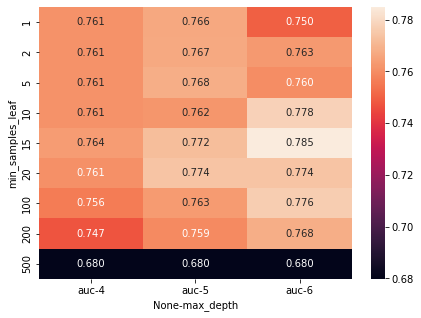

In [66]:
plt.figure(figsize=(7,5))

sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [67]:
#to experiment with other depth values

#put the above in dataframe to be readable

scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, s, auc))  

In [68]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4.0,1,0.761283
1,4.0,2,0.761283
2,4.0,5,0.761283
3,4.0,10,0.761283
4,4.0,15,0.763726


In [69]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10.0,15,0.789016
49,15.0,15,0.787732
58,20.0,15,0.787218
41,10.0,20,0.786370
67,NaN,15,0.786067


In [70]:
df_scores_pivot = df_scores.pivot_table(index='min_samples_leaf', columns='max_depth', values=['auc'])
df_scores_pivot.round(3)

auc                                          
max_depth          4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                 
1                 0.761  0.766  0.756  0.752  0.690  0.660  0.654
2                 0.761  0.766  0.756  0.754  0.722  0.696  0.684
5                 0.761  0.768  0.762  0.757  0.735  0.714  0.717
10                0.761  0.762  0.778  0.765  0.768  0.766  0.759
15                0.764  0.772  0.786  0.780  0.789  0.788  0.787
20                0.761  0.774  0.773  0.780  0.786  0.782  0.783
100               0.756  0.763  0.776  0.780  0.780  0.779  0.780
200               0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

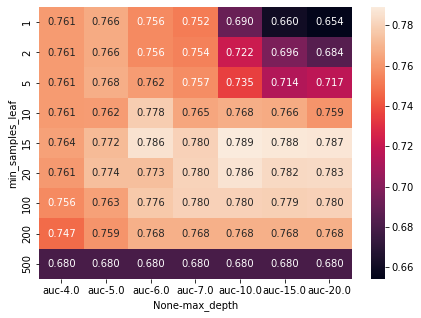

In [71]:
plt.figure(figsize=(7,5))

sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

<Figure size 288x216 with 0 Axes>

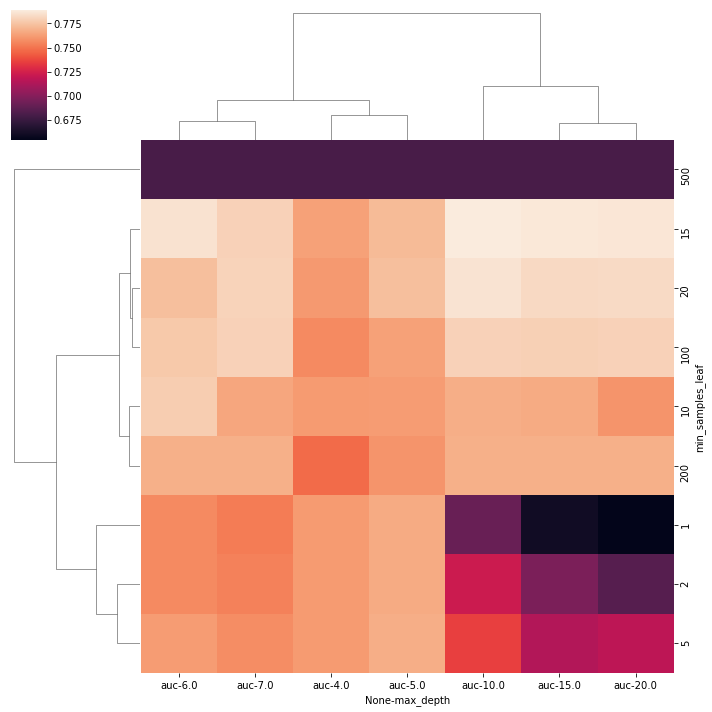

In [72]:
plt.figure(figsize=(4,3))

sns.clustermap(df_scores_pivot)

In [73]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)     #6 and 15 are the best parameters 
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

# 6.6- Ensembles and Random Forest

#Random forest is the way of putting multiple decision trees together. This involves different decision tree models training different features randomly from the dataset to get different scores. After this, we compute the average score of all 3 tree models. In random forest, number of estimators equals number of forest to use. Without random state set, predictions will be random at al times.

In [1]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)

In [76]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [77]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [78]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

#to get the same outcome at all times, fix the random state. Try the forest with different types of n_estimators.

In [79]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [80]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


Text(0, 0.5, 'AUC')

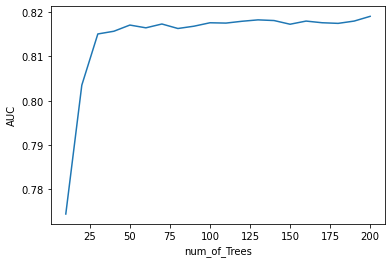

In [81]:
plt.plot(df_scores['n_estimators'], df_scores['auc'])
plt.xlabel('num_of_Trees')
plt.ylabel('AUC')

#From the plot above, after tree 50, there was no significant increase in the AUC, which indicates any tree after 50 was unnecessary. Tune other parameters below for random forest, just like decision tree

In [82]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, n, auc))

In [83]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878
5,5,60,0.801167
6,5,70,0.802251
7,5,80,0.803244
8,5,90,0.803616
9,5,100,0.804452


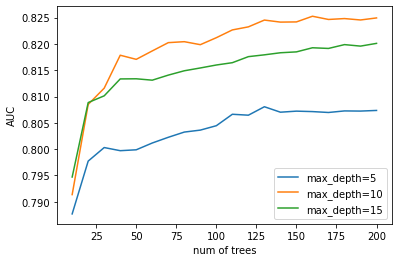

In [84]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores['max_depth'] == d]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label = 'max_depth=%s' % d)
    plt.ylabel('AUC')
    plt.xlabel('num of trees')
    
plt.legend()                      #from the plot below, 10 is the best max_depth at 125 trees estimator

In [85]:
max_depth = 10           #use this to train for min_sample depth below

In [86]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((s, n, auc))

In [87]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


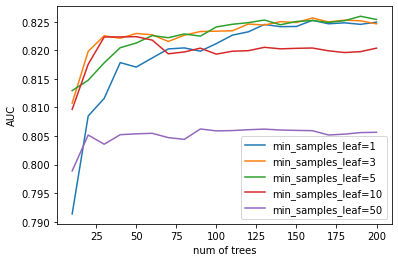

In [88]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores['min_samples_leaf'] == s]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label = 'min_samples_leaf=%s' % s)
    plt.ylabel('AUC')
    plt.xlabel('num of trees')
    
plt.legend()                                                  #min_samples_leaf = 3 seems the best bur close to 1 and 5.

In [89]:
min_samples_leaf = 3

In [90]:
rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                            n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

#Check these other random forest parameters out: max_features(number of features used by each random tree) and bootstrap(for rows)

# 6.7- Gradient Boosting and XGBoost

#Another way of combining multiple tree forests (models) into one ensemble, where one tree(model) corrects the errors on preceding tree(model). The errors got from the first tree is use to predict the next model and the combination continues until the final predictions. This process is known as Gradient Boosting Trees. Install xgboost for this process.

In [91]:
!pip install xgboost

In [92]:
import xgboost as xgb

In [95]:
features = dv.get_feature_names()                                        #DMatrix data structure trains xgboost faster
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [96]:
#eta=learning rate, verbosity-num of error, min_child_weight-min_sanple_leaf(node), max_depth-how many layers

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

C:\Users\emman\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [21:01:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


In [97]:
y_pred = model.predict(dval)

In [98]:
roc_auc_score(y_val, y_pred)

0.8072491584122448

In [99]:
#to train 10 trees and calculate the roc_score

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

C:\Users\emman\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [21:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


In [100]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8065256351262986

#always check the num_boost_round to avoid overfitting by using low numbers. To monitor Xgboost trainng for evaluation, do the following below:

In [134]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [135]:
xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200)

[0]	train-auc:0.86730	val-auc:0.77938
[1]	train-auc:0.89140	val-auc:0.78964
[2]	train-auc:0.90699	val-auc:0.79010
[3]	train-auc:0.91677	val-auc:0.79967
[4]	train-auc:0.92246	val-auc:0.80443
[5]	train-auc:0.93086	val-auc:0.80858
[6]	train-auc:0.93675	val-auc:0.80981
[7]	train-auc:0.94108	val-auc:0.80872
[8]	train-auc:0.94809	val-auc:0.80456
[9]	train-auc:0.95100	val-auc:0.80653
[10]	train-auc:0.95447	val-auc:0.80851
[11]	train-auc:0.95672	val-auc:0.81052
[12]	train-auc:0.95818	val-auc:0.81389
[13]	train-auc:0.96071	val-auc:0.81270
[14]	train-auc:0.96333	val-auc:0.81265
[15]	train-auc:0.96554	val-auc:0.81334
[16]	train-auc:0.96669	val-auc:0.81510
[17]	train-auc:0.96951	val-auc:0.81573
[18]	train-auc:0.97113	val-auc:0.81667
[19]	train-auc:0.97261	val-auc:0.81811
[20]	train-auc:0.97464	val-auc:0.81729
[21]	train-auc:0.97560	val-auc:0.81780
[22]	train-auc:0.97653	val-auc:0.81656
[23]	train-auc:0.97773	val-auc:0.81636
[24]	train-auc:0.97809	val-auc:0.81613
[25]	train-auc:0.97953	val-auc:0.81

C:\Users\emman\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [21:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	train-auc:0.98251	val-auc:0.81624
[28]	train-auc:0.98451	val-auc:0.81755
[29]	train-auc:0.98543	val-auc:0.81656
[30]	train-auc:0.98579	val-auc:0.81543
[31]	train-auc:0.98617	val-auc:0.81514
[32]	train-auc:0.98791	val-auc:0.81462
[33]	train-auc:0.98901	val-auc:0.81408
[34]	train-auc:0.98953	val-auc:0.81317
[35]	train-auc:0.99011	val-auc:0.81206
[36]	train-auc:0.99038	val-auc:0.81167
[37]	train-auc:0.99108	val-auc:0.80996
[38]	train-auc:0.99236	val-auc:0.80937
[39]	train-auc:0.99305	val-auc:0.80980
[40]	train-auc:0.99421	val-auc:0.80922
[41]	train-auc:0.99459	val-auc:0.80901
[42]	train-auc:0.99481	val-auc:0.80947
[43]	train-auc:0.99527	val-auc:0.80950
[44]	train-auc:0.99537	val-auc:0.80983
[45]	train-auc:0.99548	val-auc:0.80842
[46]	train-auc:0.99575	val-auc:0.80827
[47]	train-auc:0.99602	val-auc:0.80777
[48]	train-auc:0.99613	val-auc:0.80863
[49]	train-auc:0.99634	val-auc:0.80930
[50]	train-auc:0.99653	val-auc:0.80918
[51]	train-auc:0.99681	val-auc:0.81110
[52]	train-auc:0.99686	va

In [136]:
#outcome of every 5 evaluation:

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206


C:\Users\emman\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [21:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.00000	val-auc:0.80727
[130]	train-auc:1.00000	val-auc:0.80746
[135]	train-auc:1.00000	val-auc:0.80753
[140]	train-auc:1.00000	val-auc:0.80899
[145]	train-auc:1.00000	val-auc:0.80733
[150]	train-auc:1.00000	val-auc:0.80841
[155]	train-auc:1.00000	val-auc:0.80734
[160]	train-auc:1.00000	val-auc:0.80711
[165]	train-

In [137]:
%%capture output

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [138]:
output.stdout

'[0]\ttrain-auc:0.86730\tval-auc:0.77938\n[5]\ttrain-auc:0.93086\tval-auc:0.80858\n[10]\ttrain-auc:0.95447\tval-auc:0.80851\n[15]\ttrain-auc:0.96554\tval-auc:0.81334\n[20]\ttrain-auc:0.97464\tval-auc:0.81729\n[25]\ttrain-auc:0.97953\tval-auc:0.81686\n[30]\ttrain-auc:0.98579\tval-auc:0.81543\n[35]\ttrain-auc:0.99011\tval-auc:0.81206\n[40]\ttrain-auc:0.99421\tval-auc:0.80922\n[45]\ttrain-auc:0.99548\tval-auc:0.80842\n[50]\ttrain-auc:0.99653\tval-auc:0.80918\n[55]\ttrain-auc:0.99765\tval-auc:0.81114\n[60]\ttrain-auc:0.99817\tval-auc:0.81172\n[65]\ttrain-auc:0.99887\tval-auc:0.80798\n[70]\ttrain-auc:0.99934\tval-auc:0.80870\n[75]\ttrain-auc:0.99965\tval-auc:0.80555\n[80]\ttrain-auc:0.99979\tval-auc:0.80549\n[85]\ttrain-auc:0.99988\tval-auc:0.80374\n[90]\ttrain-auc:0.99993\tval-auc:0.80409\n[95]\ttrain-auc:0.99996\tval-auc:0.80548\n[100]\ttrain-auc:0.99998\tval-auc:0.80509\n[105]\ttrain-auc:0.99999\tval-auc:0.80629\n[110]\ttrain-auc:1.00000\tval-auc:0.80637\n[115]\ttrain-auc:1.00000\tval-au

In [139]:
print(output.stdout)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [140]:
s = output.stdout

In [141]:
line = s.split('\n')[0]              #to split by \n from the first line

In [142]:
line.split('\t')                      #to split by \t from the first line

['[0]', 'train-auc:0.86730', 'val-auc:0.77938']

In [143]:
num_iter, train_auc, val_auc = line.split('\t')

In [144]:
int(num_iter.strip('[]'))                        #to remove the brackets and convert string to integers.

0

In [145]:
float(train_auc.split(':')[1])                  #to remove the colon and convert string to float

0.8673

In [146]:
float(val_auc.split(':')[1])                      ##to remove the brackets and convert string to integers.

0.77938

#do the above for every line of the output with a function:

In [147]:
results = []

def parse_xgb_output(output):
   
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train= float(train_line.split(':')[1])
        val= float(val_line.split(':')[1])
        
        
        results.append((it, train, val))
        
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [148]:
df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
7,35,0.99011,0.81206
8,40,0.99421,0.80922
9,45,0.99548,0.80842


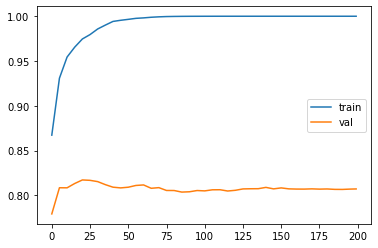

In [149]:
plt.plot(df_score['num_iter'], df_score['train_auc'], label = 'train')
plt.plot(df_score['num_iter'], df_score['val_auc'], label = 'val')
plt.legend()

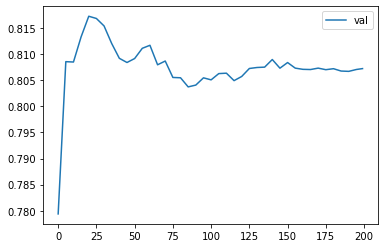

In [150]:
plt.plot(df_score['num_iter'], df_score['val_auc'], label = 'val')
plt.legend()

# 6.8- XGBoost Paramter Tuning:

#Tuning the following: learning-rate(eta), max_depth(how far the mode/tree go), min_child_weight(number of leaves)

In [151]:
scores = {}

In [152]:
%%capture output

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [153]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [154]:
scores

{'eta=0.3':     num_iter  train_auc  val_auc
 0          0    0.86730  0.77938
 1          5    0.93086  0.80858
 2         10    0.95447  0.80851
 3         15    0.96554  0.81334
 4         20    0.97464  0.81729
 ..       ...        ...      ...
 77       180    1.00000  0.80723
 78       185    1.00000  0.80678
 79       190    1.00000  0.80672
 80       195    1.00000  0.80708
 81       199    1.00000  0.80725
 
 [82 rows x 3 columns]}

In [155]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
...,...,...,...
77,180,1.00000,0.80723
78,185,1.00000,0.80678
79,190,1.00000,0.80672
80,195,1.00000,0.80708


#if eta=1.0, 0 >= eta <= 1

In [156]:
%%capture output

xgb_params = {
    'eta' : 1.0,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [157]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

#if eta=0.1

In [158]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [159]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

#if eta=0.05,

In [160]:
%%capture output

xgb_params = {
    'eta' : 0.05,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [161]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

#if eta=0.01,

In [162]:
%%capture output

xgb_params = {
    'eta' : 0.01,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [163]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [164]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

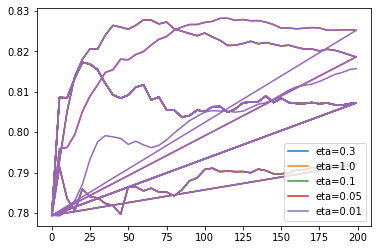

In [167]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

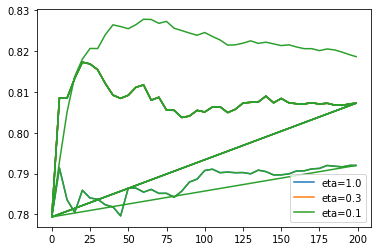

In [170]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score['num_iter'], df_score['val_auc'], label=eta)
plt.legend()

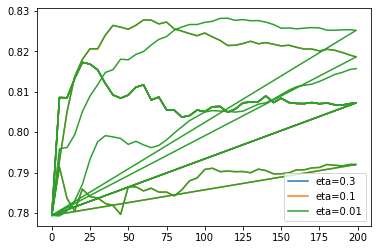

In [171]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score['num_iter'], df_score['val_auc'], label = eta)
plt.legend()

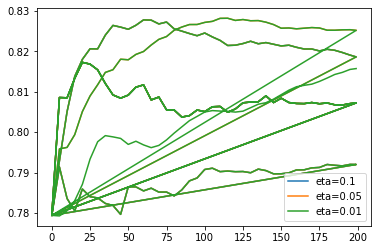

In [172]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score['num_iter'], df_score['val_auc'], label = eta)
plt.legend()

#from the plots above, though not clear enough, 0.1 is the best eta and will be used to tune max_depth(how far the mode/tree go), min_child_weight(min_sample_leaves)

In [184]:
scores = {}

In [185]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 6,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [186]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [187]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 3,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [188]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [189]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 4,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [190]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=4'

In [191]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 10,
    'min_child_weigth': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [194]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [195]:
del scores['max_depth=10']           #we delete bcos it's worse than others

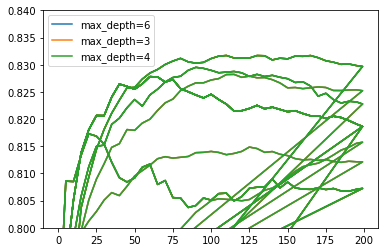

In [197]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

#from the above plot, max_depth 3 is the best with auc. We'll use 0.3 and eta 0.1 to tune min_child_weight

In [214]:
scores = {}

In [215]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [216]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [217]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [218]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [219]:
%%capture output

xgb_params = {
    'eta' : 0.1,
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [220]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

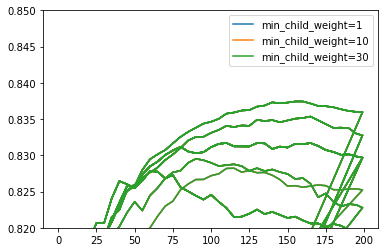

In [222]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score['num_iter'], df_score['val_auc'], label=min_child_weight)

plt.ylim(0.82, 0.85)
plt.legend()

In [224]:
#the final trained model with min_child_weight 1, eta 0.1, max_depth 3 and num_boost_round 175 

xgb_params = {
    'eta' : 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

#tune other parameters: subsample and colsample_bytree with different numbers

# 6.9- Selecting the final model

#Combine all the best trained models of decision tree, random forest and xgboost, predict y_val and get roc_auc_score

In [225]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)     #6 and 15 are the best parameters 
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [228]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.785470804775859

In [230]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [231]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [232]:
#the final trained model with min_child_weight 1, eta 0.1, max_depth 3 and num_boost_round 175 

xgb_params = {
    'eta' : 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [233]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8309347073212081

#from the diff roc_auc above xgboost score is the best and will be used to train final model. xgboost is difficult to tune with lots of parameters, and sometimes overfit but can get better performance.

In [236]:
df_full_train = df_full_train.reset_index(drop=True)

In [238]:
y_full_train = (df_full_train['status'] == 'default').astype(int).values
y_full_train

array([0, 1, 0, ..., 0, 0, 1])

In [239]:
del df_full_train['status']

In [241]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [244]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [245]:
#the final trained model with min_child_weight 1, eta 0.1, max_depth 3 and num_boost_round 175 

xgb_params = {
    'eta' : 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [247]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8289367577342261